In [2]:
# Importing the necessary libraries for the project. 
import pandas as pd 
import yfinance as yf
import numpy as np # for numerical operations
import seaborn as sns #visualisation
import matplotlib.pyplot as plt # visualization
%matplotlib inline 
import matplotlib.ticker as ticker # Library to customize ticks
from datetime import date
import matplotlib.dates as mdates
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from math import sqrt
# Mean Squared Error and Mean Absolute Error metrics from sklearn for evaluating model accuracy.
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from sklearn.metrics import mean_squared_error, mean_absolute_error
# TimeSeriesSplit for cross-validation with time series data to preserve the temporal ordering of data.
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterSampler
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization, Dropout, Dense, LSTM
import random
import optuna
from optuna.samplers import TPESampler
from keras_tuner import BayesianOptimization

import warnings # filter warnings
warnings.filterwarnings('ignore')

In [3]:
# Importing the dataset after the Log Returns transformation.
df1 = pd.read_csv('df1.csv', index_col=0, parse_dates=True)

# Along with the importation, the code will set the date as the index, value of 0 because is the first column.
## Setting parse_dates=true to ensure the dates are in datetime, making more appropriate for ML models.

In [4]:
df1.describe()

,Close,lag_1,lag_4,rolling_mean_4w,rolling_mean_12w,volatility_4w
count,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000
mean,0.001575,0.001608,0.001508,0.001578,0.001516,7.731465
std,0.020723,0.020744,0.020750,0.009796,0.005364,23.505939
min,-0.069935,-0.069935,-0.069935,-0.051352,-0.026288,0.154122
25%,-0.007633,-0.007633,-0.007858,-0.003032,-0.001013,1.538535
50%,0.003635,0.003666,0.003626,0.002937,0.002346,2.585030
75%,0.013568,0.013643,0.013514,0.007596,0.004979,6.157669
max,0.051947,0.051947,0.051947,0.031089,0.019145,338.128664


In [5]:
# Define the selected exogenous variables and target variable.
features = df1[['rolling_mean_4w', 'rolling_mean_12w', 'volatility_4w', 'lag_1', 'lag_4']]
target = df1['Close']

In [6]:
# Split data into training and testing sets.
train_size = int(0.85 * len(features))
X_train, X_test = features[:train_size], features[train_size:]
y_train, y_test = target[:train_size], target[train_size:]

# Initialize MinMaxScalers to scale data to the range [-1, 1].
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))

# Fit scalers on training data and transform both training and test data.
X_train_scaled = scaler_X.fit_transform(X_train)  # Fit scaler on training features and transform.
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))  # Fit scaler on training target and transform.

# Transform test data without fitting again to avoid data leakage.
X_test_scaled = scaler_X.transform(X_test)  # Transform test features using the scaler fitted on training data.
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))  # Transform test target using the scaler fitted on training data.

# Print minimum and maximum values of the scaled training and test data for verification.
print("Scaled Training Features - Min:", X_train_scaled.min(), "Max:", X_train_scaled.max())
print("Scaled Training Target - Min:", y_train_scaled.min(), "Max:", y_train_scaled.max())
print("Scaled Test Features - Min:", X_test_scaled.min(), "Max:", X_test_scaled.max())
print("Scaled Test Target - Min:", y_test_scaled.min(), "Max:", y_test_scaled.max())

Scaled Training Features - Min: -1.0 Max: 1.0
Scaled Training Target - Min: -1.0 Max: 0.9999999999999999
Scaled Test Features - Min: -1.0 Max: 4.748476030153254
Scaled Test Target - Min: -1.0 Max: 0.9999999999999999


## Sequence Length = 4 

In [8]:
# Set the sequence length for LSTM input, representing the number of time steps.
sequence_length = 4  # Number of time steps used for target prediction, 4 weeks.

# Reshape data into sequences for LSTM.
# Initialize empty lists to hold the sequences for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the training data to create sequences of features and corresponding target values.
for i in range(len(X_train_scaled) - sequence_length):
    # Append a sequence of features for the current window.
    X_train_seq.append(X_train_scaled[i:i + sequence_length]) # Sequence of features.
    # Append the target value that comes immediately after the sequence.
    y_train_seq.append(y_train_scaled[i + sequence_length]) # Target value following the sequence.
# Initialize empty lists to hold the sequences for the test set    
X_test_seq, y_test_seq = [], []
# Same process for the test sets.
for i in range(len(X_test_scaled) - sequence_length):
    # Append a sequence of features for the current window in the test set.
    X_test_seq.append(X_test_scaled[i:i + sequence_length])
    # Append the target value immediately after the sequence in the test set.
    y_test_seq.append(y_test_scaled[i + sequence_length])

# Convert lists to numpy arrays to use in Neural Networks.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input data for LSTM.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")
print(f"Reshaped  y_test_seq shape: { y_test_seq.shape}")

Reshaped X_train_seq shape: (872, 4, 5)
Reshaped y_train_seq shape: (872, 1)
Reshaped X_test_seq shape: (151, 4, 5)
Reshaped  y_test_seq shape: (151, 1)


### Random Parameters. (Model 1)

In [9]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define hyperparameters
dropout_rate = 0.3          # Dropout rate to help prevent overfitting by randomly dropping nodes during training.
l2_lambda = 0.01            # L2 regularization factor, penalizes large weights and attempt to prevent overfitting.
learning_rate = 0.0002      # Learning rate for the optimizer to control how much to adjust weights during backpropagation.
epochs = 50                 # Maximum number of training epochs.
batch_size = 128            # Batch size for each training step, determines how many samples are used in each gradient update.

# Initialize the LSTM model.
model = Sequential()

# First LSTM layer with L2 regularization and dropout.
model.add(LSTM(units=64,                    # Number of LSTM units (neurons) in the layer.
               return_sequences=True,       # Ensures that the layer returns the entire sequence for the next LSTM layer.
               input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape: (sequence length, number of features).
               kernel_regularizer=l2(l2_lambda)))  # Applies L2 regularization to reduce overfitting.
model.add(Dropout(dropout_rate))            # Adds dropout layer to reduce overfitting by randomly setting some neurons to 0.

# Second LSTM layer with L2 regularization and dropout.
model.add(LSTM(units=64,                    # Number of LSTM units in the second layer.
               return_sequences=False,      # Last LSTM layer should not return sequences; it outputs only the final state.
               kernel_regularizer=l2(l2_lambda)))  # L2 regularization to prevent overfitting.
model.add(Dropout(dropout_rate))            # Dropout for regularization.

# Output layer
model.add(Dense(1))                         # Dense layer with a single unit, since its predicting a single value (regression).

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),  # Adam optimizer with a specified learning rate.
              loss='mean_squared_error')                    # Mean Squared Error (MSE) as the loss function for regression.

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss',          # Monitor validation loss to stop if it stops improving.
                               patience=10,                 # Wait for 10 epochs with no improvement before stopping.
                               restore_best_weights=True)   # Restore model weights from the epoch with the lowest validation loss.

# Train the model
history = model.fit(X_train_seq, y_train_seq,               # Training data (features and target).
                    epochs=epochs,                          # Maximum number of epochs.
                    batch_size=batch_size,                  # Batch size.
                    validation_data=(X_test_seq, y_test_seq),  # Validation data to monitor overfitting.
                    callbacks=[early_stopping],             # Callback for early stopping. 
                    shuffle=False,
                    verbose=1)                              # Verbose output for progress during training.

# Print final training and validation loss values.
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - loss: 1.2371 - val_loss: 1.2218
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.1956 - val_loss: 1.1838
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.1582 - val_loss: 1.1495
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.1252 - val_loss: 1.1177
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.0954 - val_loss: 1.0874
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.0647 - val_loss: 1.0580
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.0347 - val_loss: 1.0294
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0074 - val_loss: 1.0016
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.9798 - val_loss: 0.9746
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.9544 - val_loss: 0.9484
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.9275 - val_loss: 0.9230
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9026 - val_loss: 0.8983


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
LSTM Model Performance:
Training RMSE: 0.020314455269155252
Test RMSE: 0.023123872296837152
Training MAE: 0.014739463882543874
Test MAE: 0.01761689452726008
Directional Accuracy on Training Data: 51.43513203214696%
Directional Accuracy on Test Data: 52.0%


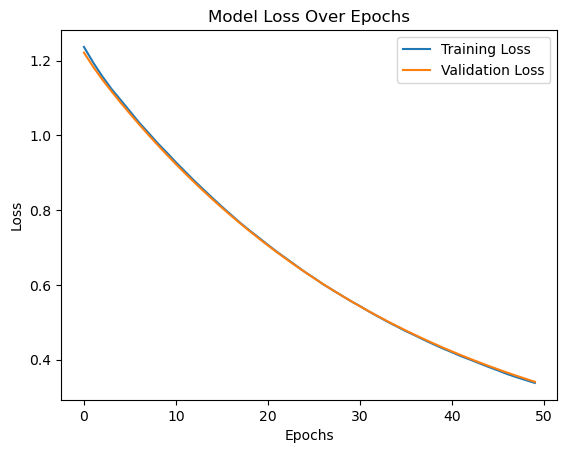

In [10]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 2

In [12]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 64,
    'units3': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'huber_loss',
    'learning_rate_decay': 1e-6,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 150,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    callbacks=[early_stopping],
    shuffle=False,
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 2.6348 - val_loss: 0.4189
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5496 - val_loss: 0.4135
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3137 - val_loss: 0.4124
Epoch 4/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1985 - val_loss: 0.4118
Epoch 5/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1538 - val_loss: 0.4100
Epoch 6/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9565 - val_loss: 0.4078
Epoch 7/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9465 - val_loss: 0.4046
Epoch 8/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8697 - val_loss: 0.4000
Epoch 9/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7981 - val_loss: 0.3952
Epoch 10/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7915 - val_loss: 0.3931
Epoch 11/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7333 - val_loss: 0.3885
Epoch 12/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
LSTM Model Performance:
Training RMSE: 0.019941764887832156
Test RMSE: 0.023330304649123633
Training MAE: 0.014341672913890324
Test MAE: 0.01762012678185044
Directional Accuracy on Training Data: 59.01262916188289%
Directional Accuracy on Test Data: 52.0%


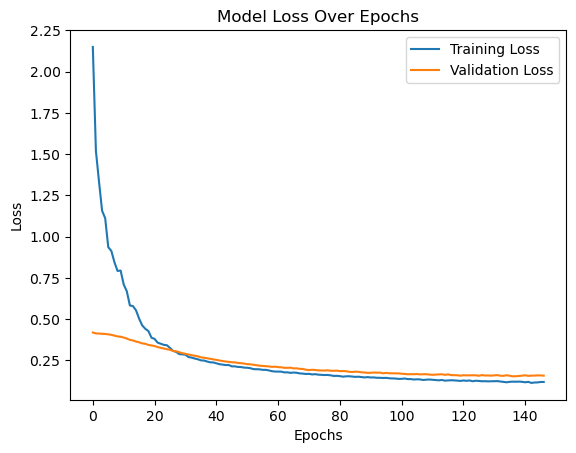

In [13]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 1.Random Search 

### Two Layers (Model 3)

In [16]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 0.15291404724121094
Final Validation Loss: 0.1699262112379074
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 0.8291551470756531
Final Validation Loss: 0.6107314229011536
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 0.9499660730361938
Final Validation Loss: 0.3035249412059784
Running combination

In [34]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 1.6953 - val_loss: 0.2133
Epoch 2/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3776 - val_loss: 0.2094
Epoch 3/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0675 - val_loss: 0.2084
Epoch 4/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0660 - val_loss: 0.2084
Epoch 5/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9442 - val_loss: 0.2089
Epoch 6/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7416 - val_loss: 0.2072
Epoch 7/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7200 - val_loss: 0.2068
Epoch 8/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6494 - val_loss: 0.2062
Epoch 9/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4691 - val_loss: 0.2035
Epoch 10/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4322 - val_loss: 0.2018
Epoch 11/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3582 - val_loss: 0.2014
Epoch 12/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
LSTM Model Performance:
Training RMSE: 0.02038309010392759
Test RMSE: 0.022973741159911368
Training MAE: 0.014790372016464057
Test MAE: 0.017618449356682518
Directional Accuracy on Training Data: 61.882893226176805%
Directional Accuracy on Test Data: 51.33333333333333%


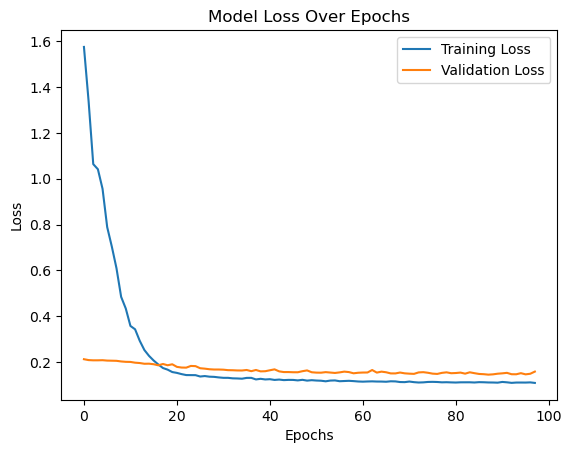

In [36]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Three Layers (Model 4)

In [20]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 0.11058776825666428
Final Validation Loss: 0.1438879519701004
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 3.23075532913208
Final Validation Loss: 2.73872709274292
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 1.627591848373413
Final Validati

In [22]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.1,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    callbacks=[early_stopping],
    shuffle=False
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 13.4038 - val_loss: 10.3586
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11.0829 - val_loss: 9.2126
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.7346 - val_loss: 8.1123
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.5419 - val_loss: 7.1304
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.6010 - val_loss: 6.2975
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.6380 - val_loss: 5.5659
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.9677 - val_loss: 4.9359
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.2437 - val_loss: 4.3920
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6489 - val_loss: 3.9295
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2564 - val_loss: 3.5312
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9122 - val_loss: 3.1854
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss:

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
LSTM Model Performance:
Training RMSE: 0.0205118824370475
Test RMSE: 0.02305943075310435
Training MAE: 0.014811615142594131
Test MAE: 0.01743595933085359
Directional Accuracy on Training Data: 55.223880597014926%
Directional Accuracy on Test Data: 53.333333333333336%


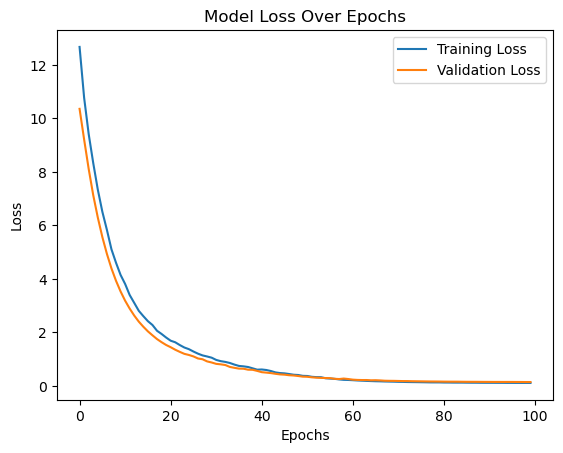

In [23]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2. Optuna (Model 5) 

In [24]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of an LSTM model.
    Takes a trial object from Optuna and returns the validation loss of the model with given parameters.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate for LSTM layers.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Set input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-13 22:05:50,007] A new study created in memory with name: no-name-1776b06a-ebda-4baf-a193-63eb7841a69b
[I 2024-11-13 22:05:59,725] Trial 0 finished with value: 0.5658991932868958 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 0.5658991932868958.
[I 2024-11-13 22:06:06,987] Trial 1 finished with value: 2.5200958251953125 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 0.5658991932868958.
[I 2024-11-13 22:06:23,010] Trial 2 finished with value: 2.4657230377197266 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0

Best hyperparameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0151867360016515, 'learning_rate': 0.001, 'learning_rate_decay': 0, 'clipnorm': 1.0, 'units': 64, 'num_layers': 2, 'epochs': 150, 'batch_size': 64}
Best validation loss: 0.1311413198709488


In [64]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'units2': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda':  0.0151867360016515,
    'epochs': 150,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 4.0277 - val_loss: 1.7664
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0139 - val_loss: 1.6824
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0577 - val_loss: 1.6041
Epoch 4/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7362 - val_loss: 1.5199
Epoch 5/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4927 - val_loss: 1.4370
Epoch 6/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3444 - val_loss: 1.3537
Epoch 7/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2194 - val_loss: 1.2698
Epoch 8/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9157 - val_loss: 1.1867
Epoch 9/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7669 - val_loss: 1.1054
Epoch 10/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6056 - val_loss: 1.0213
Epoch 11/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5633 - val_loss: 0.9507
Epoch 12/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
LSTM Model Performance:
Training RMSE: 0.020429289257174195
Test RMSE: 0.023033736753495335
Training MAE: 0.014797507612470435
Test MAE: 0.017420660276589818
Directional Accuracy on Training Data: 56.831228473019515%
Directional Accuracy on Test Data: 58.666666666666664%


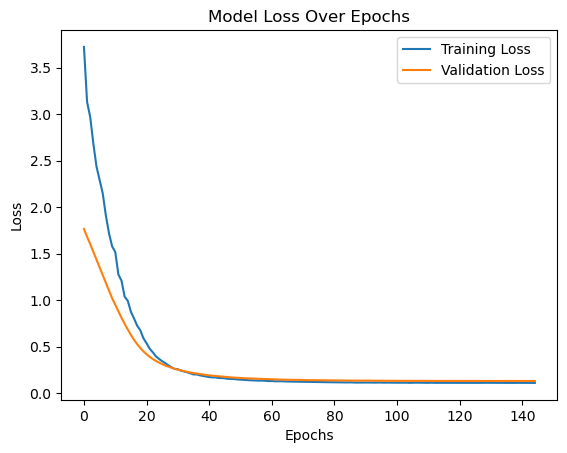

In [65]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3. Keras Tuner (Model 6) 

In [28]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build model function with hyperparameter choices.
def build_model(hp): #hp (kerastuner.HyperParameters) - Hyperparameter search space.
    model = Sequential()
    
    # Define hyperparameters using `hp` for various tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates to fight overfitting.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout for LSTM layers.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization factor.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate choices.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay for gradual reduction.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm to prevent exploding gradients.
    units = hp.Choice("units", [32, 64, 128])  # Number of units for LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size choices.


    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)
        model.add(LSTM(units=units, return_sequences=return_sequences,
                       input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
                       kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
        model.add(BatchNormalization()) # Add batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Add dropout to help with overfitting.

    model.add(Dense(1))  # Output layer for a single continuous value.
    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
     # Compile model with specified optimizer and mean squared error loss.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")
    
    return model

# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_model,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of times to execute each trial.
    directory="tuner_dir",  # Directory to store tuning results.
    project_name="lstm_tuning_capstone",  # Tuning project name.
    overwrite=True  # Overwrite existing tuner results if present.
)

# Define early stopping.
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# Perform tuning with verbose logging.
tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=200,
    callbacks=[early_stopping],
    shuffle=False,
    verbose=1  # Ensure output of each trial.
)

# Retrieve the best model and hyperparameters.
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:", best_hyperparameters.values)
print("Best batch size:", best_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 06s]
val_loss: 0.14044289290905

Best val_loss So Far: 0.13999874889850616
Total elapsed time: 00h 12m 45s
Built model with params: dropout_rate=0.3, recurrent_dropout=0.2, l2_lambda=0.07913979537147964, learning_rate=0.001, learning_rate_decay=1e-05, clipnorm=5.0, units=32, num_layers=2, batch_size=64
Best hyperparameters: {'dropout_rate': 0.3, 'recurrent_dropout': 0.2, 'l2_lambda': 0.07913979537147964, 'learning_rate': 0.001, 'learning_rate_decay': 1e-05, 'clipnorm': 5.0, 'units': 32, 'num_layers': 2, 'batch_size': 64}
Best batch size: 64


In [71]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.001,
    'l2_lambda': 0.07913979537147964,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    callbacks=[early_stopping],
    shuffle=False
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 278ms/step - loss: 7.2129 - val_loss: 4.5267
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 5.6316 - val_loss: 4.0535
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0528 - val_loss: 3.6056
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.3184 - val_loss: 3.1942
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.7722 - val_loss: 2.8428
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.5323 - val_loss: 2.5371
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.1224 - val_loss: 2.2734
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.8322 - val_loss: 2.0404
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.6262 - val_loss: 1.8427
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.3146 - val_loss: 1.6691
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.1390 - val_loss: 1.5154
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/st

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
LSTM Model Performance:
Training RMSE: 0.020419093498409226
Test RMSE: 0.023013218380415243
Training MAE: 0.014854729799560932
Test MAE: 0.01746791887816428
Directional Accuracy on Training Data: 56.48679678530425%
Directional Accuracy on Test Data: 57.99999999999999%


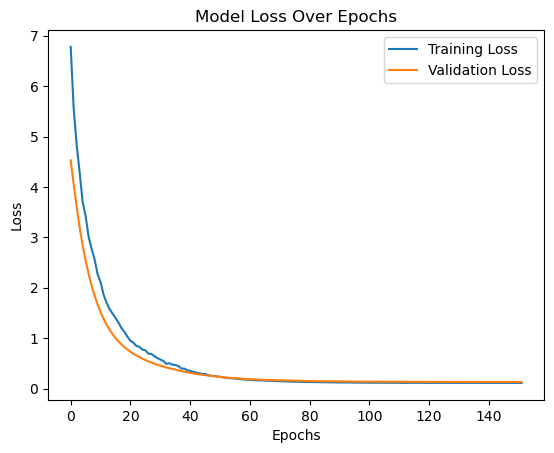

In [73]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model Performance Metrics for Sequence Length = 4

| Metric         | Model 1       | Model 2       | Model 3       | Model 4       | Model 5       | Model 6       |
|-----------------|---------------|---------------|---------------|---------------|---------------|---------------|
| **Train RMSE** | 0.020314455   | 0.019941765   | 0.02038309    | 0.020511882   | 0.020429289   | 0.020419093   |
| **Test RMSE**  | 0.023123872   | 0.023330305   | 0.022973741   | 0.023059431   | 0.023033737   | 0.023013218   |
| **Train MAE**  | 0.014739464   | 0.014341673   | 0.014790372   | 0.014811615   | 0.014797508   | 0.01485473    |
| **Test MAE**   | 0.017616895   | 0.017620127   | 0.017618449   | 0.017435959   | 0.01742066    | 0.017467919   |
| **Train Loss** | 0.337355286   | 0.118890353   | 0.109886877   | 0.110587768   | 0.110946737   | 0.111690558   |
| **Val Loss**   | 0.340427399   | 0.157293305   | 0.159300119   | 0.143887952   | 0.131491527   | 0.130892992   |
| **Train DA**   | 51%           | 59%           | 62%           | 55%           | 57%           | 56%           |
| **Test DA**    | 52%           | 52%           | 51%           | 53%           | 59%           | 58%           |

**Key:**
- RMSE: Root Mean Squared Error
- MAE: Mean Absolute Error
- Loss: Training or Validation Loss
- DA: Directional Accuracy


**The best model for the sequence length is the model 6**, which presented the best overall balance between all score metrics (it has lowest validation loss). The loss plot also shows convergence, but the early stop approach can be improved.  

In [ ]:
# Extracting train and val loss:
scaled_train_loss = history.history['loss'][-1]  # Final train loss
scaled_val_loss = history.history['val_loss'][-1]  # Final validation loss

# Descale train and validation loss
descaled_train_loss = np.sqrt(scaled_train_loss) * scaler_y.scale_[0] + scaler_y.mean_[0]
descaled_val_loss = np.sqrt(scaled_val_loss) * scaler_y.scale_[0] + scaler_y.mean_[0]

print(f"Descaled Training Loss: {descaled_train_loss}")
print(f"Descaled Validation Loss: {descaled_val_loss}")

In [16]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Best hyperparameters
best_params = {
    'units1': 32,
    'units2': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.001,
    'l2_lambda': 0.07913979537147964,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    optimizer = Adam(learning_rate=params['learning_rate'], 
                     decay=params['learning_rate_decay'], 
                     clipnorm=params['clipnorm'])
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=params['loss_function'])
    
    return model

# Define the number of splits for Time Series Cross-Validation
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the list to store RMSE scores
tscv_rmse_scores = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create the model once and save its initial weights
model = build_best_model(best_params)
initial_weights = model.get_weights()

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(X_train_scaled)):
    print(f"Fold {fold + 1}")

    # Reset model to initial weights
    model.set_weights(initial_weights)
    
    # Define train and test sets
    train, test = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_fold, y_test_fold = y_train_scaled[train_index], y_train_scaled[test_index]
    
    # Create sequences
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate the average RMSE across all folds
avg_rmse = np.mean(tscv_rmse_scores)
print(f"Average RMSE from TSCV: {avg_rmse}")

Fold 1
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
Fold 1 RMSE: 0.4631680777453844
Fold 2
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 2 RMSE: 0.34029729053570823
Fold 3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Fold 3 RMSE: 0.28589442666716053
Fold 4
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Fold 4 RMSE: 0.3745123836050248
Average RMSE from TSCV: 0.3659680446383195


In [17]:
# Parameters for FRWCV
train_window = 300  # Training window size
test_window = 50    # Test window size

# Store RMSEs for each window
rolling_rmse_scores = []

for start in range(0, len(X_train_scaled) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define train and test sets for the window
    train = X_train_scaled[start:start + train_window]
    test = X_train_scaled[start + train_window:start + train_window + test_window]
    y_train_fold = y_train_scaled[start:start + train_window]
    y_test_fold = y_train_scaled[start + train_window:start + train_window + test_window]
    
    # Create sequences for train and test
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Build and train the model
    model = build_best_model(best_params)
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        verbose=0,  # Suppress training logs for brevity
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
Rolling window RMSE: 0.43233682281389846
Rolling window starting at index 50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/stepWARNING:tensorflow:5 out of the last 23 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000182578E4860> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
Rolling window RMSE: 0.43825290430280806
Roll

In [ ]:
# Function to descale RMSE
def descale_rmse(scaled_rmse, scaler_y):
    # Reshape RMSE value to fit scaler requirements
    scaled_rmse_array = np.array(scaled_rmse).reshape(-1, 1)
    # Inverse transform the RMSE
    descaled_rmse_array = scaler_y.inverse_transform(scaled_rmse_array)
    # Return the descaled RMSE as a list
    return descaled_rmse_array.flatten().tolist()

# Descale TSCV RMSE values
descaled_tscv_rmse = descale_rmse(tscv_rmse_scores, scaler_y)
print("Descaled TSCV RMSE Values:", descaled_tscv_rmse)

# Descale FRWCV RMSE values
descaled_frwcv_rmse = descale_rmse(rolling_rmse_scores, scaler_y)
print("Descaled FRWCV RMSE Values:", descaled_frwcv_rmse)

# Calculates average descaled RMSE
average_tscv_rmse = np.mean(descaled_tscv_rmse)
average_frwcv_rmse = np.mean(descaled_frwcv_rmse)
print(f"Average Descaled TSCV RMSE: {average_tscv_rmse}")
print(f"Average Descaled FRWCV RMSE: {average_frwcv_rmse}")

## Sequence Length = 12 

In [18]:
# Set the sequence length for LSTM input, representing the number of time steps.
sequence_length = 12  # Number of time steps used for target prediction, 12 weeks (Quarterly).

# Reshape data into sequences for LSTM.
# Initialize empty lists to hold the sequences for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the training data to create sequences of features and corresponding target values.
for i in range(len(X_train_scaled) - sequence_length):
    # Append a sequence of features for the current window.
    X_train_seq.append(X_train_scaled[i:i + sequence_length]) # Sequence of features.
    # Append the target value that comes immediately after the sequence.
    y_train_seq.append(y_train_scaled[i + sequence_length]) # Target value following the sequence.
# Initialize empty lists to hold the sequences for the test set    
X_test_seq, y_test_seq = [], []
# Same process for the test sets.
for i in range(len(X_test_scaled) - sequence_length):
    # Append a sequence of features for the current window in the test set.
    X_test_seq.append(X_test_scaled[i:i + sequence_length])
    # Append the target value immediately after the sequence in the test set.
    y_test_seq.append(y_test_scaled[i + sequence_length])

# Convert lists to numpy arrays to use in Neural Networks.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input data for LSTM.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")
print(f"Reshaped  y_test_seq shape: { y_test_seq.shape}")

Reshaped X_train_seq shape: (864, 12, 5)
Reshaped y_train_seq shape: (864, 1)
Reshaped X_test_seq shape: (143, 12, 5)
Reshaped  y_test_seq shape: (143, 1)


### 1. Random Search (Two Layers - Model 1)

In [36]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 0.14561107754707336
Final Validation Loss: 0.17564596235752106
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 0.4619697630405426
Final Validation Loss: 0.28401193022727966
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 0.9323776364326477
Final Validation Loss: 0.3091294467449188
Running combinati

In [84]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.01,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 51s 281ms/step - loss: 3.0575 - val_loss: 0.7773
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2.2273 - val_loss: 0.7678
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8906 - val_loss: 0.7495
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.8049 - val_loss: 0.7394
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.5532 - val_loss: 0.7305
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.7807 - val_loss: 0.7223
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.5988 - val_loss: 0.7145
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.3658 - val_loss: 0.7062
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.4922 - val_loss: 0.6979
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.4402 - val_loss: 0.6930
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.3451 - val_loss: 0.6834
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/st

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 492ms/step
LSTM Model Performance:
Training RMSE: 0.020650653082081912
Test RMSE: 0.02398720453603505
Training MAE: 0.014889153505638218
Test MAE: 0.018062194723975394
Directional Accuracy on Training Data: 59.09617612977984%
Directional Accuracy on Test Data: 58.45070422535211%


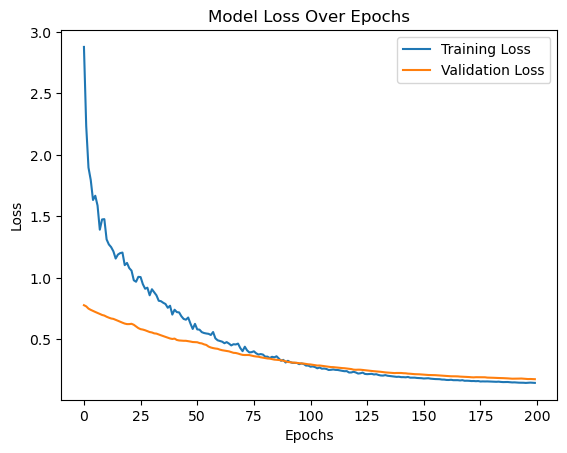

In [86]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Three Layers (Model 2)

In [40]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 0.20096047222614288
Final Validation Loss: 0.35382428765296936
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 3.2474517822265625
Final Validation Loss: 2.83465576171875
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 1.6059890985488892
Final Vali

In [100]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 45s 580ms/step - loss: 2.1614 - val_loss: 0.3189
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 1.1942 - val_loss: 0.3102
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.9990 - val_loss: 0.3110
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 1.0028 - val_loss: 0.3147
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.9405 - val_loss: 0.3175
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.8650 - val_loss: 0.3199
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.8744 - val_loss: 0.3190
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.8281 - val_loss: 0.3182
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.8611 - val_loss: 0.3219
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.8374 - val_loss: 0.3221
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.8146 - val_loss: 0.3198
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.7330 - val_

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 982ms/step
LSTM Model Performance:
Training RMSE: 0.020370913039071313
Test RMSE: 0.023233765016554893
Training MAE: 0.014775606984168
Test MAE: 0.017562496871755574
Directional Accuracy on Training Data: 48.319814600231744%
Directional Accuracy on Test Data: 51.40845070422535%


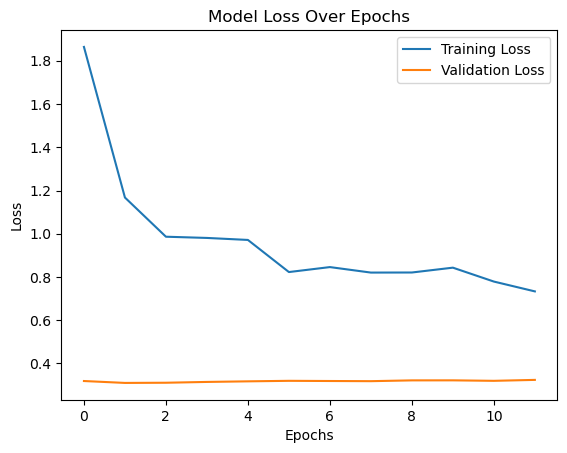

In [101]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2. Optuna (Model 3) 

In [44]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of an LSTM model.
    Takes a trial object from Optuna and returns the validation loss of the model with given parameters.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate for LSTM layers.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Set input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-13 22:32:14,447] A new study created in memory with name: no-name-c9d044eb-ca59-40ef-8769-266c8cf0d699
[I 2024-11-13 22:32:22,921] Trial 0 finished with value: 0.5691806674003601 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 0.5691806674003601.
[I 2024-11-13 22:32:30,036] Trial 1 finished with value: 2.5420398712158203 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 0.5691806674003601.
[I 2024-11-13 22:32:52,254] Trial 2 finished with value: 2.4158737659454346 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0

Best hyperparameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.1, 'l2_lambda': 0.042448918017048726, 'learning_rate': 0.001, 'learning_rate_decay': 0, 'clipnorm': 5.0, 'units': 32, 'num_layers': 3, 'epochs': 200, 'batch_size': 120}
Best validation loss: 0.12486433982849121


In [112]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.042448918017048726,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 64s 790ms/step - loss: 8.4994 - val_loss: 4.7814
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 7.2147 - val_loss: 4.6490
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 6.6616 - val_loss: 4.5129
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 6.1670 - val_loss: 4.3669
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 5.9231 - val_loss: 4.2174
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 5.6068 - val_loss: 4.0675
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 5.5508 - val_loss: 3.9194
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 5.2652 - val_loss: 3.7776
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 4.9824 - val_loss: 3.6398
Epoch 10/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 4.7655 - val_loss: 3.5031
Epoch 11/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 4.5901 - val_loss: 3.3702
Epoch 12/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4.4098 - val_

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 950ms/step
LSTM Model Performance:
Training RMSE: 0.020398293380544646
Test RMSE: 0.023338731087789263
Training MAE: 0.014705354746982995
Test MAE: 0.017482875505769775
Directional Accuracy on Training Data: 52.02780996523755%
Directional Accuracy on Test Data: 51.40845070422535%


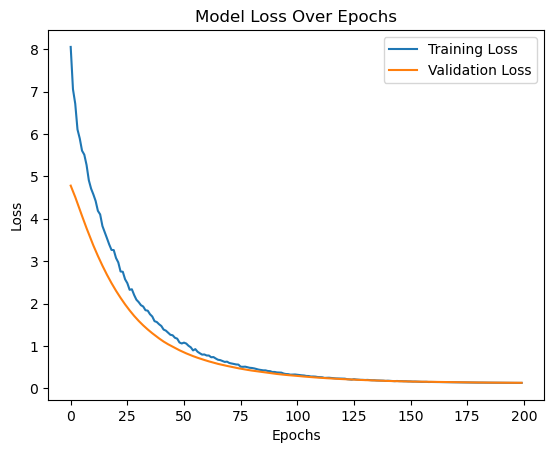

In [113]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3. Keras Tuner (Model 4) 

In [48]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build model function with hyperparameter choices.
def build_model(hp): #hp (kerastuner.HyperParameters) - Hyperparameter search space.
    model = Sequential()
    
    # Define hyperparameters using `hp` for various tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates to fight overfitting.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout for LSTM layers.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization factor.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate choices.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay for gradual reduction.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm to prevent exploding gradients.
    units = hp.Choice("units", [32, 64, 128])  # Number of units for LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size choices.


    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)
        model.add(LSTM(units=units, return_sequences=return_sequences,
                       input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
                       kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
        model.add(BatchNormalization()) # Add batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Add dropout to help with overfitting.

    model.add(Dense(1))  # Output layer for a single continuous value.
    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
     # Compile model with specified optimizer and mean squared error loss.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")
    
    return model

# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_model,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of times to execute each trial.
    directory="tuner_dir",  # Directory to store tuning results.
    project_name="lstm_tuning_capstone",  # Tuning project name.
    overwrite=True  # Overwrite existing tuner results if present.
)

# Define early stopping.
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# Perform tuning with verbose logging.
tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=200,
    callbacks=[early_stopping],
    shuffle=False,
    verbose=1  # Ensure output of each trial.
)

# Retrieve the best model and hyperparameters.
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:", best_hyperparameters.values)
print("Best batch size:", best_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 24s]
val_loss: 0.17077887058258057

Best val_loss So Far: 0.1424890011548996
Total elapsed time: 00h 10m 50s
Built model with params: dropout_rate=0.4, recurrent_dropout=0.2, l2_lambda=0.025064206402151706, learning_rate=0.0005, learning_rate_decay=1e-05, clipnorm=1.0, units=32, num_layers=3, batch_size=120
Best hyperparameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2, 'l2_lambda': 0.025064206402151706, 'learning_rate': 0.0005, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'batch_size': 120}
Best batch size: 120


In [114]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.0250642064021517066,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 69s 501ms/step - loss: 6.9052 - val_loss: 2.9285
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 5.4525 - val_loss: 2.8964
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 5.1613 - val_loss: 2.8657
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 4.8672 - val_loss: 2.8357
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.6445 - val_loss: 2.8054
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.4816 - val_loss: 2.7751
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4.6257 - val_loss: 2.7447
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4.4580 - val_loss: 2.7144
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4.3182 - val_loss: 2.6831
Epoch 10/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4.0937 - val_loss: 2.6509
Epoch 11/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4.0975 - val_loss: 2.6177
Epoch 12/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.0798 - val_

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 844ms/step
LSTM Model Performance:
Training RMSE: 0.020354193093580174
Test RMSE: 0.023208732397406222
Training MAE: 0.014738026159912635
Test MAE: 0.017424588932222252
Directional Accuracy on Training Data: 51.680185399768256%
Directional Accuracy on Test Data: 48.59154929577465%


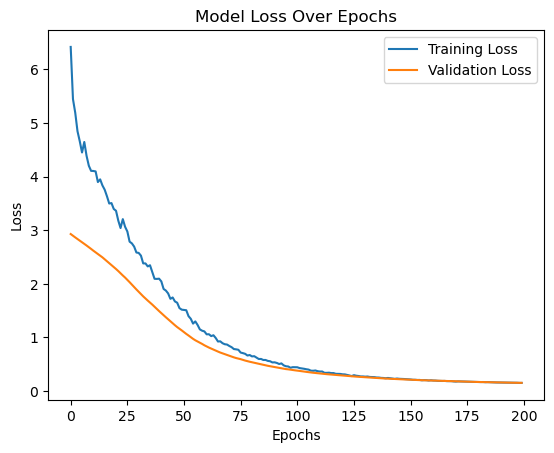

In [118]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model Performance Metrics for Sequence Length = 12

| Metric         | Model 1       | Model 2       | Model 3       | Model 4       |
|-----------------|---------------|---------------|---------------|---------------|
| **Train RMSE** | 0.020650653   | 0.020370913   | 0.020398293   | 0.020354193   |
| **Test RMSE**  | 0.023987205   | 0.023233765   | 0.023338731   | 0.023208732   |
| **Train MAE**  | 0.014889154   | 0.014775607   | 0.014705355   | 0.014738026   |
| **Test MAE**   | 0.018062195   | 0.017562497   | 0.017482876   | 0.017424589   |
| **Train Loss** | 0.145611078   | 0.733473957   | 0.127861217   | 0.150918424   |
| **Val Loss**   | 0.175645962   | 0.324159324   | 0.131033525   | 0.152491331   |
| **Train DA**   | 59%           | 48%           | 52%           | 52%           |
| **Test DA**    | 54%           | 51%           | 51%           | 49%           |

The model 2, 3 and 4 have similiar RMSE and MAE metrics, but looking at the train and val loss model 3 has the lowest val loss and its curve decreases smoother than other models (2,4). **Thus, the optimal model for the sequence length of 12 is the model 3**.

In [23]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.042448918017048726,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    optimizer = Adam(learning_rate=params['learning_rate'], 
                     decay=params['learning_rate_decay'], 
                     clipnorm=params['clipnorm'])
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=params['loss_function'])
    
    return model

# Define the number of splits for Time Series Cross-Validation
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the list to store RMSE scores
tscv_rmse_scores = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create the model once and save its initial weights
model = build_best_model(best_params)
initial_weights = model.get_weights()

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(X_train_scaled)):
    print(f"Fold {fold + 1}")

    # Reset model to initial weights
    model.set_weights(initial_weights)
    
    # Define train and test sets
    train, test = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_fold, y_test_fold = y_train_scaled[train_index], y_train_scaled[test_index]
    
    # Create sequences
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate the average RMSE across all folds
avg_rmse = np.mean(tscv_rmse_scores)
print(f"Average RMSE from TSCV: {avg_rmse}")

Fold 1
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step
Fold 1 RMSE: 0.46023922150572516
Fold 2
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Fold 2 RMSE: 0.3380093209030955
Fold 3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Fold 3 RMSE: 0.2863619899364502
Fold 4
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Fold 4 RMSE: 0.40359923142451254
Average RMSE from TSCV: 0.37205244094244583


In [24]:
# Parameters for FRWCV
train_window = 300  # Training window size
test_window = 50    # Test window size

# Store RMSEs for each window
rolling_rmse_scores = []

for start in range(0, len(X_train_scaled) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define train and test sets for the window
    train = X_train_scaled[start:start + train_window]
    test = X_train_scaled[start + train_window:start + train_window + test_window]
    y_train_fold = y_train_scaled[start:start + train_window]
    y_test_fold = y_train_scaled[start + train_window:start + train_window + test_window]
    
    # Create sequences for train and test
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Build and train the model
    model = build_best_model(best_params)
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        verbose=0,  # Suppress training logs for brevity
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 831ms/step
Rolling window RMSE: 0.47248661545793624
Rolling window starting at index 50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 985ms/step
Rolling window RMSE: 0.459866164038996
Rolling window starting at index 100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 950ms/step
Rolling window RMSE: 0.31559642304483865
Rolling window starting at index 150
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 827ms/step
Rolling window RMSE: 0.2989637805595658
Rolling window starting at index 200
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step  
Rolling window RMSE: 0.29269575369105516
Rolling window starting at index 250
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 839ms/step
Rolling window RMSE: 0.3224644768210686
Rolling window starting at index 300
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 934ms/step
Rolling window RMSE: 0.3196362505415342
Rolling window starting at index 350
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 835ms/step
Rolling window RMSE: 0.22581472588850626
Rolling window starting at index 400
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 843ms/st

## Sequence Length = 26 

In [25]:
# Set the sequence length for LSTM input, representing the number of time steps.
sequence_length = 26  # Number of time steps used for target prediction, 26 weeks (Six-Months).

# Reshape data into sequences for LSTM.
# Initialize empty lists to hold the sequences for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the training data to create sequences of features and corresponding target values.
for i in range(len(X_train_scaled) - sequence_length):
    # Append a sequence of features for the current window.
    X_train_seq.append(X_train_scaled[i:i + sequence_length]) # Sequence of features.
    # Append the target value that comes immediately after the sequence.
    y_train_seq.append(y_train_scaled[i + sequence_length]) # Target value following the sequence.
# Initialize empty lists to hold the sequences for the test set    
X_test_seq, y_test_seq = [], []
# Same process for the test sets.
for i in range(len(X_test_scaled) - sequence_length):
    # Append a sequence of features for the current window in the test set.
    X_test_seq.append(X_test_scaled[i:i + sequence_length])
    # Append the target value immediately after the sequence in the test set.
    y_test_seq.append(y_test_scaled[i + sequence_length])

# Convert lists to numpy arrays to use in Neural Networks.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input data for LSTM.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")
print(f"Reshaped  y_test_seq shape: { y_test_seq.shape}")

Reshaped X_train_seq shape: (850, 26, 5)
Reshaped y_train_seq shape: (850, 1)
Reshaped X_test_seq shape: (129, 26, 5)
Reshaped  y_test_seq shape: (129, 1)


### 1. Random Search (Two Layers - Model 1)

In [56]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 0.1448913812637329
Final Validation Loss: 0.14419759809970856
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 0.6533531546592712
Final Validation Loss: 0.378877729177475
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 0.9585232138633728
Final Validation Loss: 0.28127601742744446
Running combination

In [12]:
# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.01,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 28s 276ms/step - loss: 3.2324 - val_loss: 0.7203
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 2.1663 - val_loss: 0.7147
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.9079 - val_loss: 0.7077
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.6410 - val_loss: 0.6939
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.6786 - val_loss: 0.6808
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.5574 - val_loss: 0.6718
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.5120 - val_loss: 0.6641
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.4291 - val_loss: 0.6565
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.4371 - val_loss: 0.6502
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.5034 - val_loss: 0.6434
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.2741 - val_loss: 0.6395
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/st

27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
LSTM Model Performance:
Training RMSE: 0.02048429984946356
Test RMSE: 0.025404350065667373
Training MAE: 0.01493472430189318
Test MAE: 0.019465706883975704
Directional Accuracy on Training Data: 60.541813898704355%
Directional Accuracy on Test Data: 55.46875%


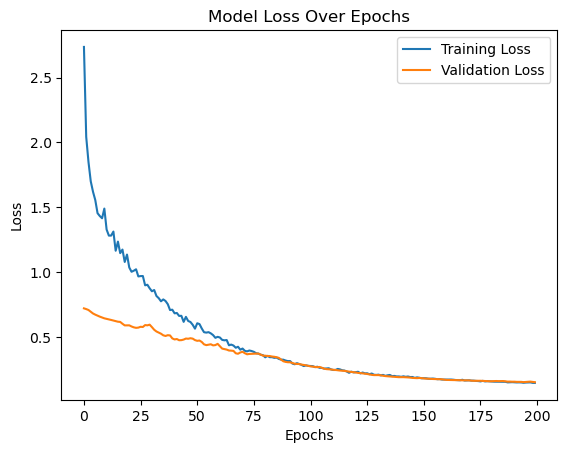

In [14]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Three Layers (Model 2)

In [60]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 0.1156860738992691
Final Validation Loss: 0.13551855087280273
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 3.3287806510925293
Final Validation Loss: 2.814274311065674
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 1.662271499633789
Final Valid

In [18]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.1,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
        
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 93ms/step - loss: 13.0333 - val_loss: 10.4712
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 11.2325 - val_loss: 9.3962
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 9.8324 - val_loss: 8.3156
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 8.7394 - val_loss: 7.3365
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 7.7628 - val_loss: 6.4972
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 6.9565 - val_loss: 5.7536
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 6.0973 - val_loss: 5.1039
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 5.3920 - val_loss: 4.5551
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 4.8919 - val_loss: 4.0645
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 4.3496 - val_loss: 3.6586
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 3.8843 - val_loss: 3.3154
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/

27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
LSTM Model Performance:
Training RMSE: 0.02054748361203847
Test RMSE: 0.02399193388254631
Training MAE: 0.01495094313670688
Test MAE: 0.01831006405625682
Directional Accuracy on Training Data: 52.65017667844523%
Directional Accuracy on Test Data: 47.65625%


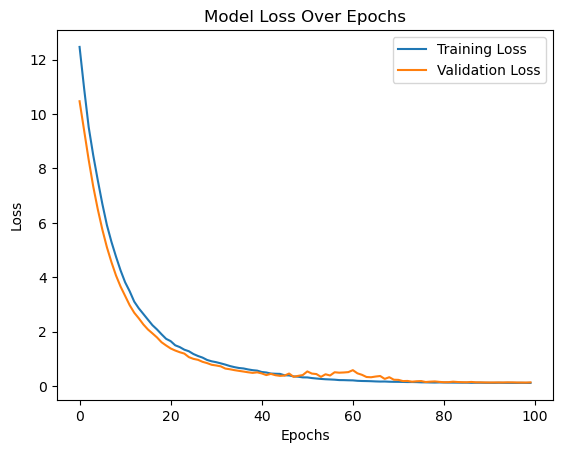

In [19]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2. Optuna (Model 3) 

In [64]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of an LSTM model.
    Takes a trial object from Optuna and returns the validation loss of the model with given parameters.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate for LSTM layers.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Set input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-13 23:01:13,341] A new study created in memory with name: no-name-972e1a98-4515-4098-82ff-c118eff63f03
[I 2024-11-13 23:01:24,036] Trial 0 finished with value: 0.5328297019004822 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 0.5328297019004822.
[I 2024-11-13 23:01:32,786] Trial 1 finished with value: 2.5555622577667236 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 0.5328297019004822.
[I 2024-11-13 23:02:11,419] Trial 2 finished with value: 2.443268299102783 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.

Best hyperparameters: {'dropout_rate': 0.2, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0010012325682668814, 'learning_rate': 0.001, 'learning_rate_decay': 1e-06, 'clipnorm': 5.0, 'units': 128, 'num_layers': 1, 'epochs': 200, 'batch_size': 64}
Best validation loss: 0.11149580031633377


In [30]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.0010012325682668814,
    'epochs': 200,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    
    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss.
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.2746 - val_loss: 0.1171
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.2142 - val_loss: 0.1199
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1865 - val_loss: 0.1165
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1751 - val_loss: 0.1161
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1797 - val_loss: 0.1168
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1681 - val_loss: 0.1162
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.2006 - val_loss: 0.1210
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2087 - val_loss: 0.1202
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1604 - val_loss: 0.1152
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1358 - val_loss: 0.1151
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1426 - val_loss: 0.1149
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
LSTM Model Performance:
Training RMSE: 0.020486305608138695
Test RMSE: 0.024209731104996263
Training MAE: 0.01504348072861271
Test MAE: 0.018667071929117787
Directional Accuracy on Training Data: 65.48881036513545%
Directional Accuracy on Test Data: 67.1875%


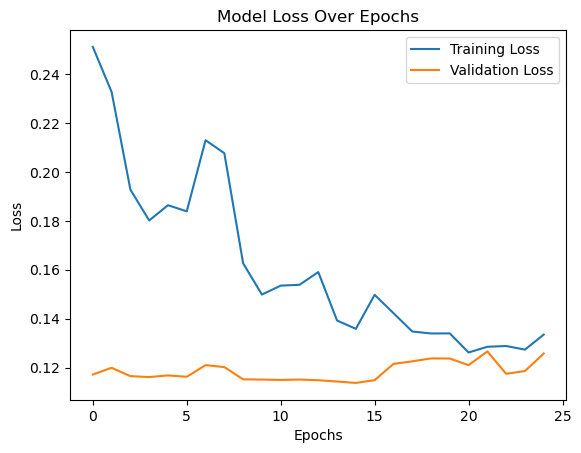

In [34]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3. Keras Tuner (Model 4) 

In [68]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build model function with hyperparameter choices.
def build_model(hp): #hp (kerastuner.HyperParameters) - Hyperparameter search space.
    model = Sequential()
    
    # Define hyperparameters using `hp` for various tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates to fight overfitting.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout for LSTM layers.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization factor.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate choices.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay for gradual reduction.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm to prevent exploding gradients.
    units = hp.Choice("units", [32, 64, 128])  # Number of units for LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size choices.


    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)
        model.add(LSTM(units=units, return_sequences=return_sequences,
                       input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
                       kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
        model.add(BatchNormalization()) # Add batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Add dropout to help with overfitting.

    model.add(Dense(1))  # Output layer for a single continuous value.
    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
     # Compile model with specified optimizer and mean squared error loss.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")
    
    return model

# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_model,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of times to execute each trial.
    directory="tuner_dir",  # Directory to store tuning results.
    project_name="lstm_tuning_capstone",  # Tuning project name.
    overwrite=True  # Overwrite existing tuner results if present.
)

# Define early stopping.
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# Perform tuning with verbose logging.
tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=200,
    callbacks=[early_stopping],
    shuffle=False,
    verbose=1  # Ensure output of each trial.
)

# Retrieve the best model and hyperparameters.
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:", best_hyperparameters.values)
print("Best batch size:", best_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 34s]
val_loss: 0.16396601498126984

Best val_loss So Far: 0.1255941092967987
Total elapsed time: 00h 15m 22s
Built model with params: dropout_rate=0.3, recurrent_dropout=0.2, l2_lambda=0.07913979537147964, learning_rate=0.001, learning_rate_decay=1e-05, clipnorm=5.0, units=32, num_layers=2, batch_size=64
Best hyperparameters: {'dropout_rate': 0.3, 'recurrent_dropout': 0.2, 'l2_lambda': 0.07913979537147964, 'learning_rate': 0.001, 'learning_rate_decay': 1e-05, 'clipnorm': 5.0, 'units': 32, 'num_layers': 2, 'batch_size': 64}
Best batch size: 64


In [38]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.001,
    'l2_lambda': 0.07913979537147964,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
        
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 40s 290ms/step - loss: 7.4105 - val_loss: 4.5741
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 5.6578 - val_loss: 4.1127
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 5.1281 - val_loss: 3.6670
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 4.5297 - val_loss: 3.2571
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 3.9601 - val_loss: 2.8921
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.4544 - val_loss: 2.5766
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.1847 - val_loss: 2.3006
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 2.9277 - val_loss: 2.0604
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.5825 - val_loss: 1.8532
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.3310 - val_loss: 1.6720
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.1012 - val_loss: 1.5136
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/st

27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
LSTM Model Performance:
Training RMSE: 0.020533080287349854
Test RMSE: 0.024094763223004478
Training MAE: 0.015166463661876461
Test MAE: 0.0185496999556951
Directional Accuracy on Training Data: 60.65959952885748%
Directional Accuracy on Test Data: 53.90625%


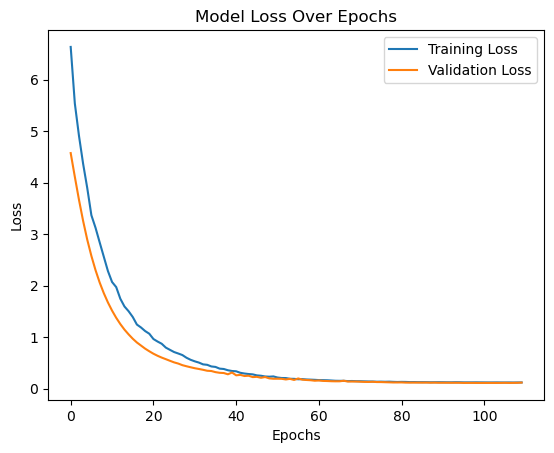

In [40]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model Performance Metrics for Sequence Length = 26

| Metric         | Model 1       | Model 2       | Model 3       | Model 4       |
|-----------------|---------------|---------------|---------------|---------------|
| **Train RMSE** | 0.0204843     | 0.020547484   | 0.020486306   | 0.02053308    |
| **Test RMSE**  | 0.02540435    | 0.023991934   | 0.024209731   | 0.024094763   |
| **Train MAE**  | 0.014934724   | 0.014950943   | 0.015043481   | 0.015166464   |
| **Test MAE**   | 0.019465707   | 0.018310064   | 0.018667072   | 0.0185497     |
| **Train Loss** | 0.145420581   | 0.115686074   | 0.133479208   | 0.118049361   |
| **Val Loss**   | 0.151149169   | 0.135518551   | 0.125732034   | 0.115593292   |
| **Train DA**   | 61%           | 53%           | 65%           | 61%           |
| **Test DA**    | 55%           | 48%           | 67%           | 54%           |

The model for sequence length did not perfomed well enough, looking at the validation loss curve throught the different models, it is observable small signs of overfitting, the curve is unstable (can see more on the model 2 plot). Thus, **the model the performed better was the model 3**, having balanced metrics. 

In [ ]:
# Extracting train and val loss:
scaled_train_loss = history.history['loss'][-1]  # Final train loss
scaled_val_loss = history.history['val_loss'][-1]  # Final validation loss

# Descale train and validation loss
descaled_train_loss = np.sqrt(scaled_train_loss) * scaler_y.scale_[0] + scaler_y.mean_[0]
descaled_val_loss = np.sqrt(scaled_val_loss) * scaler_y.scale_[0] + scaler_y.mean_[0]

print(f"Descaled Training Loss: {descaled_train_loss}")
print(f"Descaled Validation Loss: {descaled_val_loss}")

In [30]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.0010012325682668814,
    'epochs': 200,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    optimizer = Adam(learning_rate=params['learning_rate'], 
                     decay=params['learning_rate_decay'], 
                     clipnorm=params['clipnorm'])
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=params['loss_function'])
    
    return model

# Define the number of splits for Time Series Cross-Validation
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the list to store RMSE scores
tscv_rmse_scores = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create the model once and save its initial weights
model = build_best_model(best_params)
initial_weights = model.get_weights()

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(X_train_scaled)):
    print(f"Fold {fold + 1}")

    # Reset model to initial weights
    model.set_weights(initial_weights)
    
    # Define train and test sets
    train, test = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_fold, y_test_fold = y_train_scaled[train_index], y_train_scaled[test_index]
    
    # Create sequences
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate the average RMSE across all folds
avg_rmse = np.mean(tscv_rmse_scores)
print(f"Average RMSE from TSCV: {avg_rmse}")

Fold 1
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
Fold 1 RMSE: 0.46833997979179554
Fold 2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Fold 2 RMSE: 0.3154315816533551
Fold 3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Fold 3 RMSE: 0.2537473994401615
Fold 4
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Fold 4 RMSE: 0.38765997059678897
Average RMSE from TSCV: 0.35629473287052527


In [31]:
# Parameters for FRWCV
train_window = 300  # Training window size
test_window = 50    # Test window size

# Store RMSEs for each window
rolling_rmse_scores = []

for start in range(0, len(X_train_scaled) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define train and test sets for the window
    train = X_train_scaled[start:start + train_window]
    test = X_train_scaled[start + train_window:start + train_window + test_window]
    y_train_fold = y_train_scaled[start:start + train_window]
    y_test_fold = y_train_scaled[start + train_window:start + train_window + test_window]
    
    # Create sequences for train and test
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Build and train the model
    model = build_best_model(best_params)
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        verbose=0,  # Suppress training logs for brevity
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
Rolling window RMSE: 0.3991616858588019
Rolling window starting at index 50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
Rolling window RMSE: 0.5098760372077791
Rolling window starting at index 100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
Rolling window RMSE: 0.3327980303684711
Rolling window starting at index 150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
Rolling window RMSE: 0.2702229902037996
Rolling window starting at index 200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
Rolling window RMSE: 0.2557481528404545
Rolling window starting at index 250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
Rolling window RMSE: 0.31917286107168724
Rolling window starting at index 300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
Rolling window RMSE: 0.20000460366539183
Rolling window starting at index 350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
Rolling window RMSE: 0.1422835826850441
Rolling window starting at index 400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/st

In [ ]:
# Function to descale RMSE
def descale_rmse(scaled_rmse, scaler_y):
    # Reshape RMSE value to fit scaler requirements
    scaled_rmse_array = np.array(scaled_rmse).reshape(-1, 1)
    # Inverse transform the RMSE
    descaled_rmse_array = scaler_y.inverse_transform(scaled_rmse_array)
    # Return the descaled RMSE as a list
    return descaled_rmse_array.flatten().tolist()

# Descale TSCV RMSE values
descaled_tscv_rmse = descale_rmse(tscv_rmse_scores, scaler_y)
print("Descaled TSCV RMSE Values:", descaled_tscv_rmse)

# Descale FRWCV RMSE values
descaled_frwcv_rmse = descale_rmse(rolling_rmse_scores, scaler_y)
print("Descaled FRWCV RMSE Values:", descaled_frwcv_rmse)

# Calculates average descaled RMSE
average_tscv_rmse = np.mean(descaled_tscv_rmse)
average_frwcv_rmse = np.mean(descaled_frwcv_rmse)
print(f"Average Descaled TSCV RMSE: {average_tscv_rmse}")
print(f"Average Descaled FRWCV RMSE: {average_frwcv_rmse}")

## Sequence Length = 52

In [12]:
# Set the sequence length for LSTM input, representing the number of time steps.
sequence_length = 52  # Number of time steps used for target prediction, 52 weeks (One year).

# Reshape data into sequences for LSTM.
# Initialize empty lists to hold the sequences for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the training data to create sequences of features and corresponding target values.
for i in range(len(X_train_scaled) - sequence_length):
    # Append a sequence of features for the current window.
    X_train_seq.append(X_train_scaled[i:i + sequence_length]) # Sequence of features.
    # Append the target value that comes immediately after the sequence.
    y_train_seq.append(y_train_scaled[i + sequence_length]) # Target value following the sequence.
# Initialize empty lists to hold the sequences for the test set    
X_test_seq, y_test_seq = [], []
# Same process for the test sets.
for i in range(len(X_test_scaled) - sequence_length):
    # Append a sequence of features for the current window in the test set.
    X_test_seq.append(X_test_scaled[i:i + sequence_length])
    # Append the target value immediately after the sequence in the test set.
    y_test_seq.append(y_test_scaled[i + sequence_length])

# Convert lists to numpy arrays to use in Neural Networks.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input data for LSTM.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")
print(f"Reshaped  y_test_seq shape: { y_test_seq.shape}")

Reshaped X_train_seq shape: (824, 52, 5)
Reshaped y_train_seq shape: (824, 1)
Reshaped X_test_seq shape: (103, 52, 5)
Reshaped  y_test_seq shape: (103, 1)


### 1. Random Search (Two Layers - Model 1)

In [76]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 0.15308767557144165
Final Validation Loss: 0.19366386532783508
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 0.7978256940841675
Final Validation Loss: 0.588202714920044
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 0.9574838280677795
Final Validation Loss: 0.3374508023262024
Running combination

In [45]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.0005,
    'l2_lambda': 0.01,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 334ms/step - loss: 3.0706 - val_loss: 0.7894
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 2.3499 - val_loss: 0.7886
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.9940 - val_loss: 0.7685
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 1.9330 - val_loss: 0.7525
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.7718 - val_loss: 0.7405
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 1.5964 - val_loss: 0.7345
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.5072 - val_loss: 0.7254
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.6778 - val_loss: 0.7198
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 1.4700 - val_loss: 0.7134
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.4249 - val_loss: 0.7043
Epoch 11/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 1.4054 - val_loss: 0.6949
Epoch 12/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/st

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
LSTM Model Performance:
Training RMSE: 0.01979999391524998
Test RMSE: 0.02621229708819492
Training MAE: 0.014390032860653771
Test MAE: 0.020440061655561816
Directional Accuracy on Training Data: 67.67922235722965%
Directional Accuracy on Test Data: 57.84313725490197%


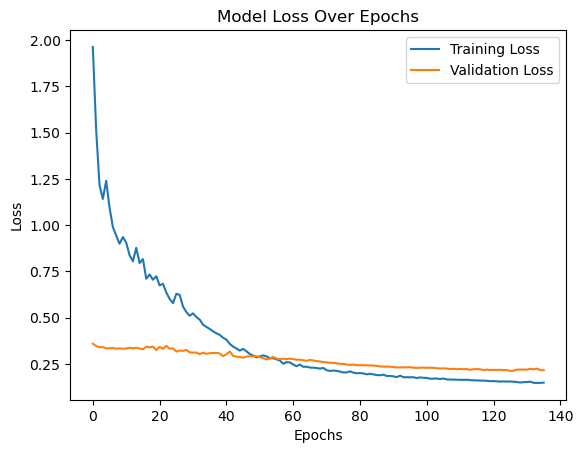

In [78]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Three Layers (Model 2)

In [80]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 0.31081756949424744
Final Validation Loss: 0.776311993598938
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 3.267017364501953
Final Validation Loss: 2.864630937576294
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 1.2463526725769043
Final Valida

In [81]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 128,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - loss: 2.2972 - val_loss: 0.3032
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1.1532 - val_loss: 0.3000
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.2281 - val_loss: 0.3031
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 1.1740 - val_loss: 0.3025
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.9092 - val_loss: 0.3018
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.8365 - val_loss: 0.3001
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.7710 - val_loss: 0.2983
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.8113 - val_loss: 0.2979
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.7847 - val_loss: 0.2988
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.7191 - val_loss: 0.2967
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.7467 - val_loss: 0.2979
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.6462 - val_l

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
LSTM Model Performance:
Training RMSE: 0.020703937886024152
Test RMSE: 0.025596058689768005
Training MAE: 0.015075211381962031
Test MAE: 0.020021269906603724
Directional Accuracy on Training Data: 54.921020656136086%
Directional Accuracy on Test Data: 53.92156862745098%


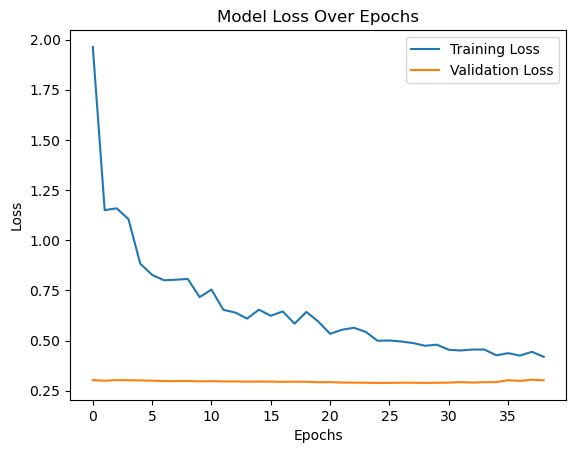

In [82]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2. Optuna (Model 3) 

In [84]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of an LSTM model.
    Takes a trial object from Optuna and returns the validation loss of the model with given parameters.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate for LSTM layers.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.
    
    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Set input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-13 23:37:04,680] A new study created in memory with name: no-name-b38a2585-1f90-44b6-baa6-e768df90429a
[I 2024-11-13 23:37:14,004] Trial 0 finished with value: 0.5938663482666016 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 0.5938663482666016.
[I 2024-11-13 23:37:25,792] Trial 1 finished with value: 2.5742692947387695 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 0.5938663482666016.
[I 2024-11-13 23:38:31,915] Trial 2 finished with value: 2.628880500793457 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.

Best hyperparameters: {'dropout_rate': 0.2, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0010193813003283602, 'learning_rate': 0.001, 'learning_rate_decay': 1e-06, 'clipnorm': 5.0, 'units': 128, 'num_layers': 1, 'epochs': 150, 'batch_size': 64}
Best validation loss: 0.161590576171875


In [55]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.0010193813003283602,
    'epochs': 150,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
     # Select the optimizer with specified parameters
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Select the loss function based on tuning results.
    if params['loss_function'] == 'huber_loss':
        loss = Huber()  # Huber loss is more robust to outliers
    else:
        loss = MeanSquaredError()  # Use MSE as default loss function for regression
    
    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters.
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping.
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss.
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 235ms/step - loss: 0.3138 - val_loss: 0.1680
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.2122 - val_loss: 0.1687
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.2021 - val_loss: 0.1664
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.1955 - val_loss: 0.1668
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.2148 - val_loss: 0.1662
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.2034 - val_loss: 0.1707
Epoch 7/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.1852 - val_loss: 0.1658
Epoch 8/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1670 - val_loss: 0.1653
Epoch 9/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.1648 - val_loss: 0.1644
Epoch 10/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.1606 - val_loss: 0.1648
Epoch 11/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1633 - val_loss: 0.1646
Epoch 12/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/st

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
LSTM Model Performance:
Training RMSE: 0.020671718128507245
Test RMSE: 0.02560304501407214
Training MAE: 0.0148340448185367
Test MAE: 0.019921678957826334
Directional Accuracy on Training Data: 67.43620899149452%
Directional Accuracy on Test Data: 65.68627450980392%


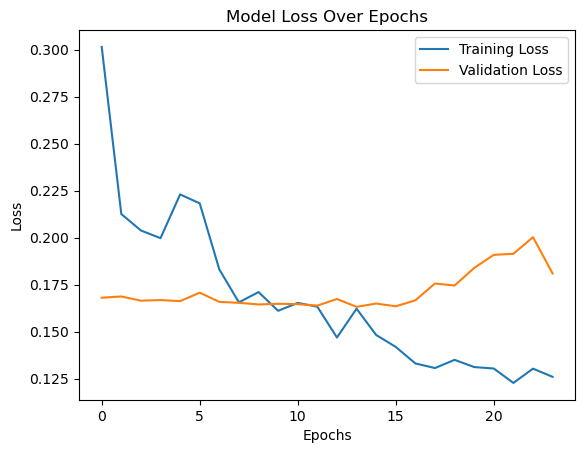

In [57]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3. Keras Tuner (Model 4) 

In [88]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build model function with hyperparameter choices.
def build_model(hp): #hp (kerastuner.HyperParameters) - Hyperparameter search space.
    model = Sequential()
    
    # Define hyperparameters using `hp` for various tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates to fight overfitting.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout for LSTM layers.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization factor.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate choices.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay for gradual reduction.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm to prevent exploding gradients.
    units = hp.Choice("units", [32, 64, 128])  # Number of units for LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size choices.

    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)
        model.add(LSTM(units=units, return_sequences=return_sequences,
                       input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
                       kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
        model.add(BatchNormalization()) # Add batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Add dropout to help with overfitting.

    model.add(Dense(1))  # Output layer for a single continuous value.
    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
     # Compile model with specified optimizer and mean squared error loss.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")
    
    return model

# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_model,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of times to execute each trial.
    directory="tuner_dir",  # Directory to store tuning results.
    project_name="lstm_tuning_capstone",  # Tuning project name.
    overwrite=True  # Overwrite existing tuner results if present.
)

# Define early stopping.
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# Perform tuning with verbose logging.
tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=200,
    callbacks=[early_stopping],
    shuffle=False,
    verbose=1  # Ensure output of each trial.
)

# Retrieve the best model and hyperparameters.
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:", best_hyperparameters.values)
print("Best batch size:", best_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 01m 12s]
val_loss: 0.17832288146018982

Best val_loss So Far: 0.15399901568889618
Total elapsed time: 00h 27m 20s
Built model with params: dropout_rate=0.3, recurrent_dropout=0.2, l2_lambda=0.07913979537147964, learning_rate=0.001, learning_rate_decay=1e-05, clipnorm=5.0, units=32, num_layers=2, batch_size=64
Best hyperparameters: {'dropout_rate': 0.3, 'recurrent_dropout': 0.2, 'l2_lambda': 0.07913979537147964, 'learning_rate': 0.001, 'learning_rate_decay': 1e-05, 'clipnorm': 5.0, 'units': 32, 'num_layers': 2, 'batch_size': 64}
Best batch size: 64


In [26]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.001,
    'l2_lambda': 0.07913979537147964,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 7.1004 - val_loss: 4.6413
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.7887 - val_loss: 4.2101
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.1766 - val_loss: 3.7745
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.6594 - val_loss: 3.3858
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.1329 - val_loss: 3.0367
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.6436 - val_loss: 2.7276
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.2509 - val_loss: 2.4579
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.0655 - val_loss: 2.2231
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.7139 - val_loss: 2.0163
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.4693 - val_loss: 1.8315
Epoch 11/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.2295 - val_loss: 1.6690
Epoch 12/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
LSTM Model Performance:
Training RMSE: 0.020611598175652383
Test RMSE: 0.02522957816660202
Training MAE: 0.014958895645402624
Test MAE: 0.019810834494472664
Directional Accuracy on Training Data: 57.95868772782503%
Directional Accuracy on Test Data: 50.98039215686274%


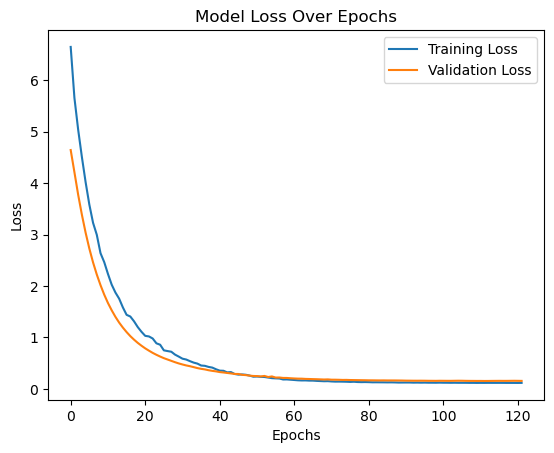

In [28]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model Performance Metrics for Sequence Length = 52

| Metric         | Model 1       | Model 2       | Model 3       | Model 4       |
|-----------------|---------------|---------------|---------------|---------------|
| **Train RMSE** | 0.019799994   | 0.020703938   | 0.020671718   | 0.020611598   |
| **Test RMSE**  | 0.026212297   | 0.025596059   | 0.025603045   | 0.025229578   |
| **Train MAE**  | 0.014390033   | 0.015075211   | 0.014834045   | 0.014958896   |
| **Test MAE**   | 0.020440062   | 0.02002127    | 0.019921679   | 0.019810834   |
| **Train Loss** | 0.153087676   | 0.419225991   | 0.125915349   | 0.117127933   |
| **Val Loss**   | 0.193663865   | 0.301946461   | 0.180938959   | 0.155745506   |
| **Train DA**   | 68%           | 55%           | 67%           | 58%           |
| **Test DA**    | 58%           | 54%           | 66%           | 51%           |

- For the sequence length of 52 the optimal model is the **Model 4**, the approach presented the lowest metrics for RMSE, train and val loss. 

In [30]:
# Extract scaled train and validation losses from history
scaled_train_loss = history.history['loss'][-1]  # Final train loss
scaled_val_loss = history.history['val_loss'][-1]  # Final validation loss

# Reshape the losses to match the expected input shape for MinMaxScaler
scaled_train_loss_reshaped = np.array(scaled_train_loss).reshape(-1, 1)
scaled_val_loss_reshaped = np.array(scaled_val_loss).reshape(-1, 1)

# Descale train and validation losses
descaled_train_loss = scaler_y.inverse_transform(scaled_train_loss_reshaped)[0, 0]
descaled_val_loss = scaler_y.inverse_transform(scaled_val_loss_reshaped)[0, 0]

# Print the descaled losses
print(f"Descaled Training Loss: {descaled_train_loss}")
print(f"Descaled Validation Loss: {descaled_val_loss}")

Descaled Training Loss: -0.001856387540864885
Descaled Validation Loss: 0.0004970015376326215


In [32]:
## Extract scaled losses from history
scaled_train_loss = history.history['loss'][-1]  # Final train loss
scaled_val_loss = history.history['val_loss'][-1]  # Final validation loss

# Retrieve the Min and Max values used in the scaler
data_min = scaler_y.data_min_[0]  # Minimum value used for scaling
data_max = scaler_y.data_max_[0]  # Maximum value used for scaling

# Compute the descaled values manually
descaled_train_loss = scaled_train_loss * (data_max - data_min) / 2 + (data_max + data_min) / 2
descaled_val_loss = scaled_val_loss * (data_max - data_min) / 2 + (data_max + data_min) / 2

# Print the descaled losses
print(f"Descaled Training Loss: {descaled_train_loss}")
print(f"Descaled Validation Loss: {descaled_val_loss}")


Descaled Training Loss: -0.0018563875408648877
Descaled Validation Loss: 0.0004970015376326194


In [34]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.001,
    'l2_lambda': 0.07913979537147964,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    optimizer = Adam(learning_rate=params['learning_rate'], 
                     decay=params['learning_rate_decay'], 
                     clipnorm=params['clipnorm'])
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=params['loss_function'])
    
    return model

# Define the number of splits for Time Series Cross-Validation
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the list to store RMSE scores
tscv_rmse_scores = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create the model once and save its initial weights
model = build_best_model(best_params)
initial_weights = model.get_weights()

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(X_train_scaled)):
    print(f"Fold {fold + 1}")

    # Reset model to initial weights
    model.set_weights(initial_weights)
    
    # Define train and test sets
    train, test = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_fold, y_test_fold = y_train_scaled[train_index], y_train_scaled[test_index]
    
    # Create sequences
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate the average RMSE across all folds
avg_rmse = np.mean(tscv_rmse_scores)
print(f"Average RMSE from TSCV: {avg_rmse}")

Fold 1
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Fold 1 RMSE: 0.504116501115201
Fold 2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Fold 2 RMSE: 0.35037178765968696
Fold 3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Fold 3 RMSE: 0.2814915249500041
Fold 4
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Fold 4 RMSE: 0.4159963505659501
Average RMSE from TSCV: 0.3879940410727105


In [ ]:
# Parameters for FRWCV
train_window = 300  # Training window size
test_window = 53    # Test window size

# Store RMSEs for each window
rolling_rmse_scores = []

for start in range(0, len(X_train_scaled) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define train and test sets for the window
    train = X_train_scaled[start:start + train_window]
    test = X_train_scaled[start + train_window:start + train_window + test_window]
    y_train_fold = y_train_scaled[start:start + train_window]
    y_test_fold = y_train_scaled[start + train_window:start + train_window + test_window]
    
    # Create sequences for train and test
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Build and train the model
    model = build_best_model(best_params)
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        verbose=0,  # Suppress training logs for brevity
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Rolling window RMSE: 0.3350777160441686
Rolling window starting at index 53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
Rolling window RMSE: 0.4008095926140036
Rolling window starting at index 106
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Rolling window RMSE: 0.30655856151243666
Rolling window starting at index 159
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Rolling window RMSE: 0.2460107838467971
Rolling window starting at index 212
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Rolling window RMSE: 0.1634210741398854
Rolling window starting at index 265
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
Rolling window RMSE: 0.36582332838996773
Rolling window starting at index 318
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Rolling window RMSE: 0.3291968926279718
Rolling window starting at index 371
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
Rolling window RMSE: 0.20821751575584208
Rolling window starting at index 424


In [ ]:
# Function to descale RMSE
def descale_rmse(scaled_rmse, scaler_y):
    # Reshape RMSE value to fit scaler requirements
    scaled_rmse_array = np.array(scaled_rmse).reshape(-1, 1)
    # Inverse transform the RMSE
    descaled_rmse_array = scaler_y.inverse_transform(scaled_rmse_array)
    # Return the descaled RMSE as a list
    return descaled_rmse_array.flatten().tolist()

# Descale TSCV RMSE values
descaled_tscv_rmse = descale_rmse(tscv_rmse_scores, scaler_y)
print("Descaled TSCV RMSE Values:", descaled_tscv_rmse)

# Descale FRWCV RMSE values
descaled_frwcv_rmse = descale_rmse(rolling_rmse_scores, scaler_y)
print("Descaled FRWCV RMSE Values:", descaled_frwcv_rmse)

# Calculates average descaled RMSE
average_tscv_rmse = np.mean(descaled_tscv_rmse)
average_frwcv_rmse = np.mean(descaled_frwcv_rmse)
print(f"Average Descaled TSCV RMSE: {average_tscv_rmse}")
print(f"Average Descaled FRWCV RMSE: {average_frwcv_rmse}")

## Evaluation of using different Sequence Length with Min and Max Scaling. 



### LSTM - MinMax Scaling Performance Metrics

| Metrics        | **SL = 4**         | SL = 12         | SL = 26         | SL = 52         |
|-----------------|----------------|-----------------|-----------------|-----------------|
| **Train RMSE** | 0.020419093    | 0.020398293     | 0.020486306     | 0.020611598     |
| **Test RMSE**  | 0.023013218    | 0.023338731     | 0.024209731     | 0.025229578     |
| **Train MAE**  | 0.01485473     | 0.014705355     | 0.015043481     | 0.014958896     |
| **Test MAE**   | 0.017467919    | 0.017482876     | 0.018667072     | 0.019810834     |
| **Train Loss** | 0.111690558    | 0.127861217     | 0.133479208     | 0.117127933     |
| **Val Loss**   | 0.130892992    | 0.131033525     | 0.125732034     | 0.155745506     |
| **Avg RMSE - TSCV** | 0.365968045 | 0.372052441     | 0.356294733     | 0.376206325     |
| **Avg RMSE - FRWCV** | 0.348539135 | 0.349066229     | 0.31970967      | 0.354697836     |
| **Train DA**   | 56%            | 52%             | 65%             | 58.00%          |
| **Test DA**    | 58%            | 51%             | 67%             | 51.00%          |

---

**Keys**

- RMSE: Root Mean Squared Error
- MAE: Mean Absolute Error.
- Loss: Training or Validation Loss.
- DA: Directional Accuracy.
- TSCV: Time-Series Cross Validation.
- RFWCV: Rolling Fixed Window Cross Validation.

---
| Sequence Length (SL) | Fold 1 RMSE | Fold 2 RMSE | Fold 3 RMSE | Fold 4 RMSE | Average RMSE (TSCV) |
|-----------------------|-------------|-------------|-------------|-------------|----------------------|
| **SL = 4**           | 0.4632      | 0.3403      | 0.2859      | 0.3745      | **0.3660**           |
| **SL = 12**          | 0.4602      | 0.3380      | 0.2864      | 0.4036      | **0.3721**           |
| **SL = 26**          | 0.4683      | 0.3154      | 0.2537      | 0.3877      | **0.3563**           |
| **SL = 52**          | 0.4975      | 0.3134      | 0.2768      | 0.4172      | **0.3762**           |
---

| Sequence Length (SL) | Rolling Window RMSE Start Index 0 | Index 50 | Index 100 | Index 150 | Index 200 | Index 250 | Index 300 | Index 350 | Index 400 | Index 450 | Index 500 | Average RMSE (FRWCV) |
|-----------------------|------------------------------------|----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------------------|
| **SL = 4**           | 0.4323                            | 0.4383   | 0.3339    | 0.3224    | 0.2904    | 0.3024    | 0.3096    | 0.2563    | 0.2936    | 0.3808    | 0.4741    | **0.3485**            |
| **SL = 12**          | 0.4725                            | 0.4599   | 0.3156    | 0.2990    | 0.2927    | 0.3225    | 0.3196    | 0.2258    | 0.2891    | 0.3345    | 0.5086    | **0.3491**            |
| **SL = 26**          | 0.3992                            | 0.5099   | 0.3328    | 0.2702    | 0.2557    | 0.3192    | 0.2000    | 0.1423    | 0.2703    | 0.2369    | 0.5803    | **0.3197**            |
| **SL = 52**          | 0.3949                            | 0.3370   | 0.4382    | 0.0881    | 0.1178    | 0.3344    | 0.2811    | 0.1673    | 0.2926    | 1.0955    | 0.3547    | **0.3547**            |

---

#### Best Model: SL = 4.

The **Sequence Legnth of 4**, which can represent approximately **One Month** yielded the most balanced performance between accuracy metrics and its cross-validation scores. It has the **lowest RMSE test** and the **values of the Average RMSE of both CV's are close**, meaning that the LSTM model is having decent generalization across different time splits. 

